In [1]:
using PyPlot
using JuLIP
using JuLIP.ASE, JuLIP.Potentials, JuLIP.Constraints 
reload("MaterialsScienceTools")

In [2]:
"a fully equilibrated SW potential"
function sw_eq()
    T(σ, at) = trace(stress(StillingerWeber(σ=σ), at))
    at = JuLIP.ASE.bulk("Si", pbc=true)
    r0 = 2.0951
    r1 = r0 - 0.1 
    s0, s1 = T(r0, at), T(r1, at)
    while (abs(s1) > 1e-8) && abs(r0 - r1) > 1e-8
        rnew = (r0 * s1 - r1 * s0) / (s1 - s0)
        r0, r1 = r1, rnew
        s0, s1 = s1, T(rnew, at)
    end
    return StillingerWeber(σ=r1)
end 

# # quick test code to confirm that sw_eq() really produces a stress free state with no internal forces
# V = sw_eq()
# at = JuLIP.ASE.bulk("Si", cubic=true, pbc=true)
# @show vecnorm(stress(V, at), Inf), maximum(norm.(forces(V, at)))


sw_eq

In [3]:
reload("MaterialsScienceTools")

function si_plane(R)
    @assert isodd(R)
    atu, b, xcore, a = MaterialsScienceTools.Dislocations_Silicon_hard_110.fcc_edge_plane("Si")
    xcore = [0.0, 0.625 * a, 0.0]
    at = atu * (R, R, 1)
    b = b[1] 
    X = positions(at) |> mat 
    X = vecs(X)
    xcore = X[length(X) ÷ 2+1] + xcore
    return at, b, xcore 
end 

function layers(at)
    X = positions(at) |> mat
    x, y, z = X[1,:], X[2,:], X[3,:] 
    I0 = find(z .== 0)
    I1 = find(z .> 0)
    return [x[I0]'; y[I0]'], [x[I1]'; y[I1]']
end 

function plot_layers(at, x0=nothing)
    X0, X1 = layers(at)
    plot(X0[1,:], X0[2,:], "b.", markersize=8)
    plot(X1[1,:], X1[2,:], "g.", markersize=8)
    if x0 != nothing 
        plot([x0[1]], [x0[2]], "r.", markersize=10)
    end 
end 


function ulin_edge_isotropic(X, b, ν)
    x, y = X[1,:], X[2,:]
    r² = x.^2 + y.^2
    ux = b/(2*π) * ( angle(x + im*y) + (x .* y) ./ (2*(1-ν) * r²) )
    uy = -b/(2*π) * ( (1-2*ν)/(4*(1-ν)) * log(r²) + - 2 * y.^2 ./ (4*(1-ν) * r²) )
    return [ux'; uy']
end

function si_edge(R) 
    at, b, xcore = si_plane(R)
    X = positions(at) |> mat
    X2d = X[1:2,:] .- xcore[1:2]
    U = ulin_edge_isotropic(X2d, b, 0.25)
    X[1:2, :] += U
    set_positions!(at, vecs(X))
    return at, JVecF(xcore)
end 

dists(at, x0) = [norm(x - x0) for x in positions(at)]


dists (generic function with 1 method)

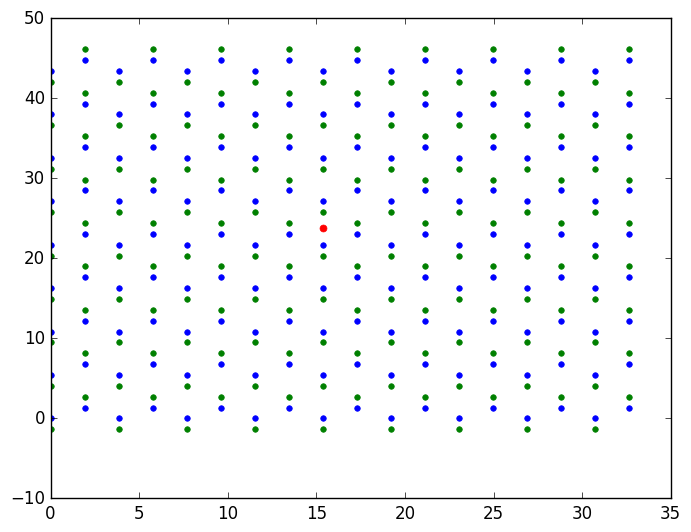

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x32ab49390>

In [4]:
at, b, x0 = si_plane(9)
plot_layers(at, x0)

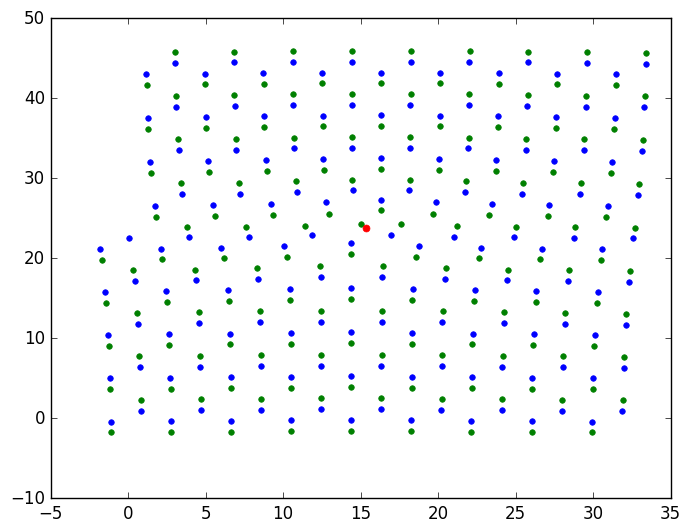

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x32aec4e50>

In [5]:
at, x0 = si_edge(9)
plot_layers(at, x0)

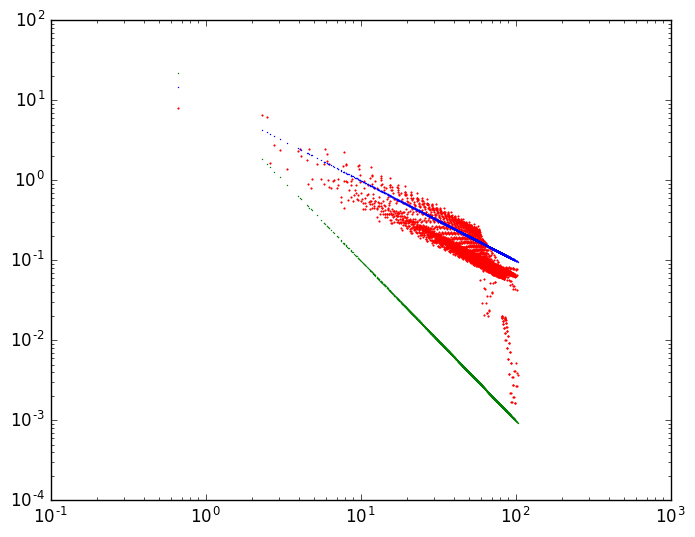

2-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x32bec7290>
 PyObject <matplotlib.lines.Line2D object at 0x32bebcdd0>

In [9]:
at, x0 = si_edge(31)
calc = sw_eq()
f = norm.(forces(calc, at))
r = dists(at, x0)
loglog(r, f, "r.", markersize=2)
loglog(r, 10*r.^(-2), "g.", r, 10*r.^(-1), "b.", markersize=1)